In [1]:
import geopandas as gpd
import pandas as pd
import pydeck as pdk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import sys

In [2]:
def set_hangul(font_path = "C:/Windows/Fonts/malgun.TTF"):
    '''
    seaborn, matplotlib, pandas로 시각화 할 때 한글출력 설정
    # 필수 import 라이브러리)
    @ seaborn
    @ matplotlib.pyplot
    @ font_manager, rc
    
    # parameter)
    @ font_path : 사용할 폰트의 경로
    '''    
    
    sns.set_theme(style="whitegrid") # seaborn 스타일 설정
    
    plt.rcParams['font.family'] = 'NanumGothic'
    sns.set(font='NanumGothic',
            rc={'axes.unicode_minus':False},
            style='darkgrid')
    
    # pandas plot 한글폰트
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

In [3]:
def coord_lister(geom):
    '''
    geometry 정보를 pydeck 형식인 coordinate list로 풀어주는 함수
    '''
    coords = list(geom.exterior.coords)
    return (coords)

In [4]:
def get_seoul_shpfile():
    root = gpd.read_file('./Data/Z_SOP_BND_ADM_DONG_PG.shp', encoding = 'cp949')
    
    root = root.set_crs(epsg = '5181').to_crs(epsg = '4326') # UTM-K 좌표계(X, Y)에서 WGS84 좌표계(lon, lat)으로 변경
    
    seoul = root.loc[root.ADM_DR_CD.str.startswith('11')] # 서울만 가져옴
    
    return seoul

In [5]:
def get_market_geo():
    market = pd.read_csv('./Data/소상공인시장진흥공단_상가(상권)정보_서울_202106.csv',
                     usecols = ['상가업소번호', '상호명', '지점명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', '경도', '위도'])
    
    market = gpd.GeoDataFrame(market, geometry=gpd.points_from_xy(market['경도'], market['위도']), crs = 'EPSG:4326') #geoDF 형식으로 변환
    
    return market

In [6]:
def get_mapping_code():
    mapping_info = pd.read_excel('./Data/행정동코드_매핑정보_2018.xlsx')
    
    mapping_info = mapping_info.rename(columns = {
        '행자부행정동코드' : '행정동코드'
    })
    
    mapper = mapping_info.loc[1:,['행정동코드', '행정동명']]
    
    mapper['행정동명'] = mapper['행정동명'].str.replace(".", "·", regex = False)
    
    mapper_dict = mapper.set_index('행정동코드', drop = True).to_dict()
    
    return mapper_dict

In [7]:
def get_population_data():
    base = pd.DataFrame()
    for i in range(1, 13):
        temp = pd.read_csv(f"./Data/local_pop/LOCAL_PEOPLE_DONG_2020{i:02d}.csv", index_col = False,
                          usecols = ['행정동코드', '총생활인구수', 
                                     '남자20세부터24세생활인구수', '남자25세부터29세생활인구수',
                                     '여자20세부터24세생활인구수', '여자25세부터29세생활인구수']) #남/여 청년인구(서울시 청년수당 지급 연령 기준)
        base = pd.concat([base, temp], axis = 0)
        
    mapper_dict = get_mapping_code()
    
    base['행정동명'] = base['행정동코드'].astype(str).map(mapper_dict['행정동명'])
    
    base.loc[base['행정동코드'] == 11680510, '행정동명'] = '신사동(강남)'
    base.loc[base['행정동코드'] == 11620685, '행정동명'] = '신사동(관악)'
    
    return base

In [8]:
def df_scaler(df, usecols, scaler = 'minmax'):
    '''
    pandas DataFrame을 스케일링 해주는 함수
    
    Parameters
    ----------
    df : 스케일링할 DataFrame
    usecols : 스케일링할 대상 칼럼명 (타입은 str, list)
    scaler : 스케일링 방법 설정 (minmax, robust, standard)
    
    Returns
    -------
    df_copy : 스케일링이 완료된 데이터셋
    '''
    
    # 2차원 이상의 데이터만 사용
    df_copy = df.copy() #원본에 영향 안주기 위해 카피
    if scaler == "minmax": 
        X = df_copy.loc[:,usecols].to_numpy() #numpy 배열로 변환
        scaler = MinMaxScaler()
        min_max_train = scaler.fit_transform(X) # 스케일링
        df_copy.loc[:,usecols] = min_max_train
        
    elif scaler == "robust":
        X = df_copy.loc[:,usecols].to_numpy()
        scaler = RobustScaler()
        robust_train = scaler.fit_transform(X)
        df_copy.loc[:,usecols] = robust_train
        
    elif scaler == "standard":
        X = df_copy.loc[:,usecols].to_numpy()
        scaler = StandardScaler()
        std_train = scaler.fit_transform(X) 
        df_copy.loc[:,usecols] = std_train
    
    else:
        print("Scaler name Error")
    return df_copy

# Main

In [9]:
set_hangul()

In [10]:
seoul = get_seoul_shpfile()

In [11]:
seoul = seoul.drop(seoul.loc[seoul['ADM_DR_CD'].isin(['항동'])].index)

In [12]:
# 항동 제외 - 인구정보가 없음

In [13]:
market = get_market_geo()

In [14]:
# food = market.loc[market['상권업종대분류명']=='음식']

In [15]:
# cafe = food.loc[food['상권업종중분류명'].str.contains('카페')]

In [16]:
# 커피 프렌차이즈 순위 출처 : http://rekorea.net/bbs/board.php?bo_table=repu6&wr_id=2600
cafe_frenz = market.loc[market['상호명'].isin(['스타벅스', '투썸플레이스', '메가커피'])]
burger_frenz = market.loc[market['상호명'].isin(['맥도날드', '버거킹', '롯데리아'])]
conv_frenz = market.loc[market['상호명'].isin(['GS25', 'CU', '세븐일레븐'])]

In [17]:
seoul['coor'] = seoul.geometry.apply(coord_lister) # pydeck에 사용하기 위해 폴리곤 좌표 리스트화

In [18]:
f = lambda x:np.sum(cafe_frenz.intersects(x)) # polygon 내부에 해당하는 point를 count
seoul['cafe_count'] = seoul['geometry'].apply(f)
f = lambda x:np.sum(burger_frenz.intersects(x)) # polygon 내부에 해당하는 point를 count
seoul['burger_count'] = seoul['geometry'].apply(f)
f = lambda x:np.sum(conv_frenz.intersects(x)) # polygon 내부에 해당하는 point를 count
seoul['conv_count'] = seoul['geometry'].apply(f)

In [19]:
seoul.loc[seoul['OBJECTID'] == '330', 'ADM_DR_NM'] = '신사동(관악)'
seoul.loc[seoul['OBJECTID'] == '359', 'ADM_DR_NM'] = '신사동(강남)'

### 치안센터 COUNT ( 치안센터; 지구대, 파출소, 치안센터)

In [20]:
popo = pd.read_csv('./Data/서울시_경찰서_지오코딩.csv')

In [21]:
popo_baby = pd.read_csv('./Data/서울시_치안센터_지오코딩.csv')

In [22]:
popo = gpd.GeoDataFrame(popo, geometry=gpd.points_from_xy(popo['lon'], popo['lat']), crs = 'EPSG:4326')
popo_baby = gpd.GeoDataFrame(popo_baby, geometry=gpd.points_from_xy(popo_baby['lon'], popo_baby['lat']), crs = 'EPSG:4326')

In [23]:
f = lambda x:np.sum(popo_baby.intersects(x))
seoul['popo_baby_count_tmp'] = seoul['geometry'].apply(f)
f = lambda x:np.sum(popo.intersects(x))
seoul['popo_count_tmp'] = seoul['geometry'].apply(f)

seoul['popo_count'] = seoul['popo_baby_count_tmp'] + seoul['popo_count_tmp']

In [24]:
cctv = pd.read_csv('./Data/서울시_CCTV_지오코딩.csv') #방범용, 회전식, 고정식만

In [25]:
cctv = gpd.GeoDataFrame(cctv, geometry = gpd.points_from_xy(cctv['WGS y좌표'], cctv['WGS x좌표']), crs = 'epsg:4326')

In [26]:
tmp = gpd.sjoin(seoul, cctv, how='left', op="intersects")

In [27]:
seoul['cctv_count'] = tmp.groupby('ADM_DR_NM', as_index=False, sort = False).sum().loc[:,'CCTV 수량']

## 정류소 COUNT

In [28]:
metro = pd.read_csv('./Data/서울시_지하철역_전처리.csv')
bus = pd.read_csv('./Data/서울시_버스정류소_전처리.csv')
bike = pd.read_csv('./Data/서울시_따릉이대여소_전처리.csv')

In [29]:
metro = gpd.GeoDataFrame(metro, geometry = gpd.points_from_xy(metro['역경도'], metro['역위도']), crs = 'epsg:4326')
bus = gpd.GeoDataFrame(bus, geometry = gpd.points_from_xy(bus['X좌표'], bus['Y좌표']), crs = 'epsg:4326')
bike = gpd.GeoDataFrame(bike, geometry = gpd.points_from_xy(bike['경도'], bike['위도']), crs = 'epsg:4326')

In [30]:
f = lambda x:np.sum(metro.intersects(x))
seoul['metro_count'] = seoul['geometry'].apply(f)
# f2 = lambda x:np.sum(bus.intersects(x))
# seoul['bus_count'] = seoul['geometry'].apply(f2)
f = lambda x:np.sum(bike.intersects(x))
seoul['bike_count'] = seoul['geometry'].apply(f)

### 인구정보 매핑

In [31]:
base = get_population_data()

In [32]:
mean_pop = base.groupby('행정동명', as_index=False).mean() #행정동별 1년 평균 생활인구

In [33]:
mean_pop['평균청년인구'] = mean_pop.iloc[:,3:].sum(axis = 1) #남성/여성 행정동별로 1년 평균된 청년인구

In [34]:
total_pop = mean_pop['총생활인구수']

In [35]:
mean_pop['청년인구비율'] = mean_pop['평균청년인구'] / mean_pop['총생활인구수']

In [36]:
mean_pop['생활인구지수'] = 25000 / mean_pop['총생활인구수']

In [37]:
mean_pop['총생활인구수'].describe() #평균 25,000 / 총생활인구수

count       424.000000
mean      24908.398065
std       11902.302619
min        4758.037873
25%       16788.105560
50%       22765.786101
75%       30590.602959
max      104456.903466
Name: 총생활인구수, dtype: float64

In [38]:
seoul_pop = seoul.merge(mean_pop.rename(columns = {'행정동명':'ADM_DR_NM'}), on = 'ADM_DR_NM')

In [39]:
# 상관관계 분석
import seaborn as sns

In [40]:
usecols = ['cafe_count','burger_count', 'conv_count', 
           'popo_baby_count_tmp', 'popo_count_tmp', 'popo_count', 'cctv_count',
           'metro_count', 'bike_count',
           '총생활인구수', '평균청년인구']
seoul_pop_cor = seoul_pop.loc[:,usecols].corr()
seoul_pop_cor = seoul_pop.loc[:,usecols].corr()

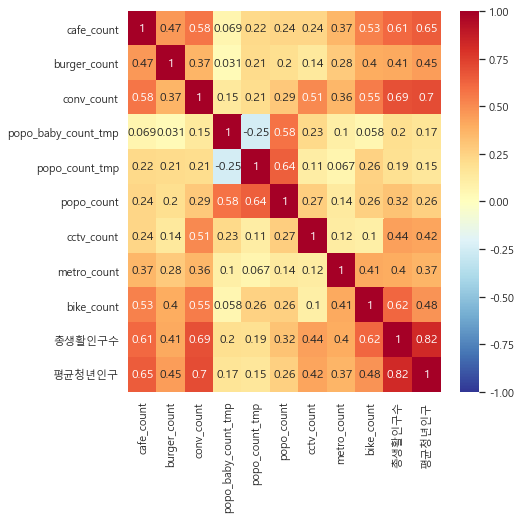

In [41]:
fig, ax = plt.subplots( figsize=(7,7))
sns.heatmap(seoul_pop_cor, 
                annot = True,      # 실제 값 화면에 나타내기
                cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
                vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
                ax = ax
           );

In [42]:
from scipy.stats import pearsonr
cafe_pearsonr = pearsonr(seoul_pop.loc[:,'총생활인구수'], seoul_pop.loc[:,'cafe_count'])
burger_pearsonr = pearsonr(seoul_pop.loc[:,'총생활인구수'], seoul_pop.loc[:,'burger_count'])
conv_pearsonr = pearsonr(seoul_pop.loc[:,'총생활인구수'], seoul_pop.loc[:,'conv_count'])
popo_pearsonr = pearsonr(seoul_pop.loc[:,'총생활인구수'], seoul_pop.loc[:,'popo_count'])
cctv_pearsonr = pearsonr(seoul_pop.loc[:,'총생활인구수'], seoul_pop.loc[:,'cctv_count'])
metro_pearsonr = pearsonr(seoul_pop.loc[:,'총생활인구수'], seoul_pop.loc[:,'metro_count'])
bike_pearsonr = pearsonr(seoul_pop.loc[:,'총생활인구수'], seoul_pop.loc[:,'bike_count'])

In [43]:
# 생활인구와 강한 상관성이 있는 것은 카페와 편의점 수였고, 반면 치안센터 수 또는 CCTV 수는 약한 상관관계를 보였다.
# 그리고 지하철 역은 약한 상관관계를 보였지만 따릉이 대여소는 생활인구수와 중간정도의 상관성을 보였다.
# p값이 모두 0.05보다 작으므로 귀무가설(상관관계가 없다) 기각, 대립가설(상관관계가 있다) 채택
print(f'<총생활인구수와 카페 대표 프렌차이즈 수의 상관관계>\n# r값 : {cafe_pearsonr[0]} # p값 : {cafe_pearsonr[1]}')
print(f'<총생활인구수와 햄버거 대표 프렌차이즈 수의 상관관계>\n# r값 : {burger_pearsonr[0]} # p값 : {burger_pearsonr[1]}')
print(f'<총생활인구수와 편의점 대표 프렌차이즈 수의 상관관계>\n# r값 : {conv_pearsonr[0]} # p값 : {conv_pearsonr[1]}')
print(f'<총생활인구수와 파출소, 지구대, 치안센터 수의 상관관계>\n# r값 : {popo_pearsonr[0]} # p값 : {popo_pearsonr[1]}')
print(f'<총생활인구수와 cctv 수의 상관관계>\n# r값 : {cctv_pearsonr[0]} # p값 : {cctv_pearsonr[1]}')
print(f'<총생활인구수와 지하철 역 수의 상관관계>\n# r값 : {metro_pearsonr[0]} # p값 : {metro_pearsonr[1]}')
print(f'<총생활인구수와 따릉이 대여소 수의 상관관계>\n# r값 : {bike_pearsonr[0]} # p값 : {bike_pearsonr[1]}')

<총생활인구수와 카페 대표 프렌차이즈 수의 상관관계>
# r값 : 0.6123532555275871 # p값 : 5.425769051582247e-45
<총생활인구수와 햄버거 대표 프렌차이즈 수의 상관관계>
# r값 : 0.40924704818946844 # p값 : 1.4963055742744776e-18
<총생활인구수와 편의점 대표 프렌차이즈 수의 상관관계>
# r값 : 0.6932752402758081 # p값 : 5.158695102996565e-62
<총생활인구수와 파출소, 지구대, 치안센터 수의 상관관계>
# r값 : 0.31592688906439614 # p값 : 2.787272279249818e-11
<총생활인구수와 cctv 수의 상관관계>
# r값 : 0.4424698198299441 # p값 : 9.401169625818668e-22
<총생활인구수와 지하철 역 수의 상관관계>
# r값 : 0.3999725903461018 # p값 : 1.0164726212809815e-17
<총생활인구수와 따릉이 대여소 수의 상관관계>
# r값 : 0.6223713779199286 # p값 : 7.866373285586064e-47


In [44]:
# 0.57, 0.4, 0.5
seoul_pop['식문화지수'] = (seoul_pop['cafe_count'] + seoul_pop['burger_count'] + seoul_pop['conv_count']) * seoul_pop['생활인구지수']# * .57
seoul_pop['범죄예방지수'] = (seoul_pop['popo_count'] + (seoul_pop['cctv_count']-seoul_pop['cctv_count'].mean())) * seoul_pop['생활인구지수']# * .4
seoul_pop['교통지수'] = (seoul_pop['metro_count'] + seoul_pop['bike_count']) * seoul_pop['생활인구지수']# * .5

In [124]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

usecols = ['식문화지수', '범죄예방지수', '교통지수']
seoul_final = df_scaler(seoul_pop, usecols, scaler='minmax')

In [125]:
seoul_final['geometry'] = seoul_pop.geometry

In [126]:
seoul_final['최종지수'] = seoul_final.loc[:,['식문화지수', '범죄예방지수', '교통지수']].sum(axis = 1)

In [127]:
seoul_final.loc[:,usecols].describe()

,식문화지수,범죄예방지수,교통지수
count,424.000000,424.000000,424.000000
mean,0.285875,0.551134,0.207053
std,0.145957,0.108208,0.129841
min,0.000000,0.000000,0.000000
25%,0.191203,0.489667,0.122561
50%,0.264615,0.558047,0.180596
75%,0.346724,0.610538,0.266467
max,1.000000,1.000000,1.000000


In [128]:
seoul_final['color'] = (seoul_final['최종지수']
                        .apply(lambda v: [0, v * 100, v * 250, 250]))
seoul_final['elev_pop'] = seoul_final['최종지수'] ** 2 * 15

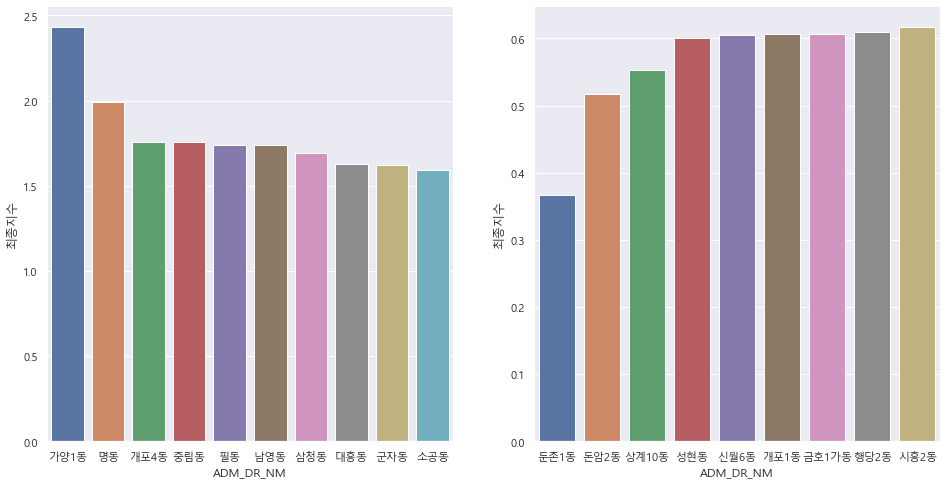

In [129]:
top_10 = (seoul_final.loc[:,['ADM_DR_NM', '최종지수']]
          .sort_values('최종지수', ascending = False).iloc[:10,:])

bot_10 = (seoul_final.loc[:,['ADM_DR_NM', '최종지수']]
          .sort_values('최종지수', ascending = False).iloc[:-10:-1,:])

fig, ax = plt.subplots(1, 2, figsize = (16,8))
sns.barplot(x = 'ADM_DR_NM', y = '최종지수', data = top_10,
            ax = ax[0]);
sns.barplot(x = 'ADM_DR_NM', y = '최종지수', data = bot_10,
            ax = ax[1]);

In [130]:
base = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    seoul_final, # 시각화에 쓰일 데이터프레임
    get_polygon = 'coor', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color = 'color', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    auto_highlight = True,
    pickable = True, 
    get_elevation = 'elev_pop',
    elevation_scale = 30,
    extruded=True,
    )

center = [126.986,37.563]
zoom = 10

view_state = pdk.ViewState(
        longitude=center[0],
        latitude=center[1],
        zoom=zoom,
        pitch = 30,
        bearing = 10
    )

text = {
    'text' : '행정동 : {ADM_DR_NM}\n<합산지수 : {최종지수}>\n 식문화지수 : {식문화지수}\n 범죄예방지수 : {범죄예방지수}\n 교통지수 : {교통지수}'
}

In [1]:
# layers = [base]
# pdk.Deck(layers=layers, initial_view_state=view_state, tooltip=text,
#          map_style = 'dark') #생활인구반영한 가게 수

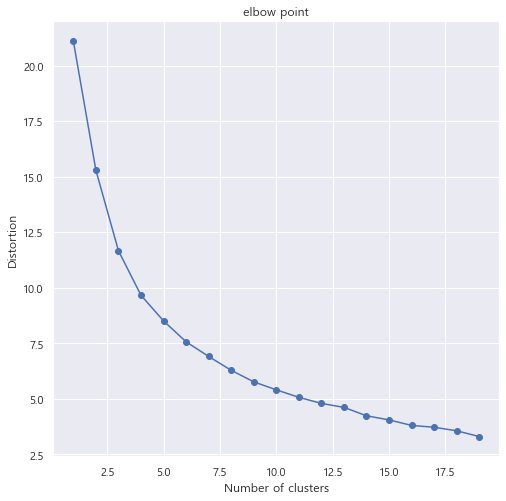

In [53]:
from sklearn.cluster import KMeans 
fig, ax = plt.subplots(1,1,figsize = (8,8))
distortions = []
use = ['식문화지수', '범죄예방지수', '교통지수']

for j in range(1, 20):
    km = KMeans(n_clusters=j)
    km.fit(seoul_final.loc[:,use])
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

ax.plot(range(1, 20), distortions, marker='o')
ax.set_title('elbow point')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Distortion')
plt.show()

In [108]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(seoul_final.loc[:,use])
labels = kmeans.labels_

In [109]:
clusters = pd.concat([seoul_final.loc[:,use],
                      pd.DataFrame({'cluster' : labels})], axis = 1)
clusters.head()

,식문화지수,범죄예방지수,교통지수,cluster
0,0.339799,0.504724,0.521392,1
1,0.766754,0.108190,0.819362,2
2,0.380237,0.547249,0.263359,0
3,0.297132,0.534868,0.246959,1
4,0.351263,0.191370,0.328443,1


In [110]:
clusters.groupby('cluster').mean()
# 0 : 중, 상, 하
# 1 : 중, 중, 중
# 2 : 상, 하, 상
# 3 : 하, 하, 하


,식문화지수,범죄예방지수,교통지수
cluster,,,
0,0.340451,0.622735,0.152236
1,0.261404,0.509459,0.356133
2,0.688912,0.490211,0.425328
3,0.172560,0.498946,0.150134


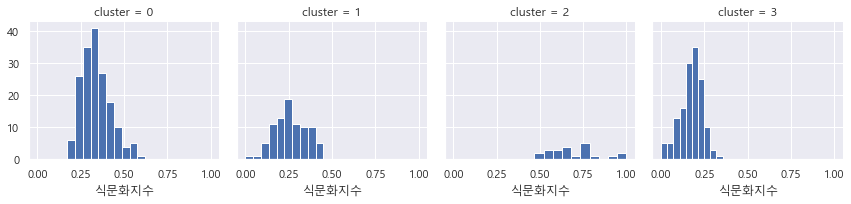

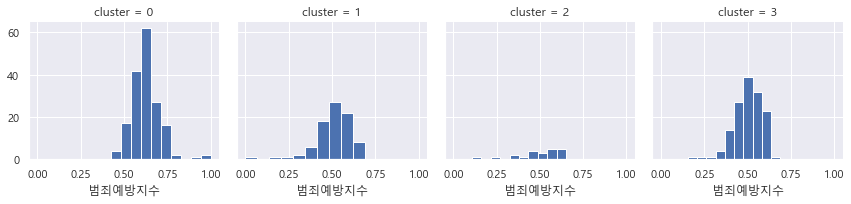

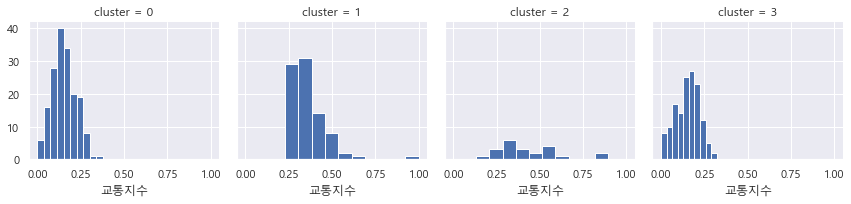

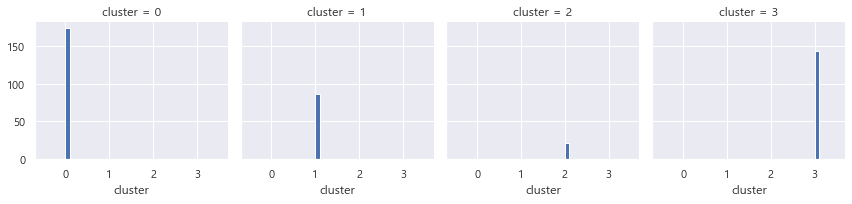

In [111]:
# for c in clusters:
#     grid= sns.FacetGrid(clusters, col='cluster')
#     grid.map(plt.hist, c)

In [112]:
cluster_final = pd.concat([clusters, seoul_final.loc[:,['ADM_DR_NM', 'geometry']]], axis = 1)

In [113]:
cluster_final['coor'] = cluster_final.geometry.apply(coord_lister)

In [114]:
c0 = cluster_final.loc[cluster_final['cluster'] == 0]
c1 = cluster_final.loc[cluster_final['cluster'] == 1]
c2 = cluster_final.loc[cluster_final['cluster'] == 2]
c3 = cluster_final.loc[cluster_final['cluster'] == 3]

In [115]:
c0_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
     c0, # 시각화에 쓰일 데이터프레임
     get_polygon = 'coor', # geometry 정보를 담고있는 컬럼 이름
     get_fill_color = '[150, 50, 0, 100]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    auto_highlight = True,
    pickable = True, 
    #get_elevation = 'elev_pop',
    #elevation_scale = 30,
    #extruded=True,
    )
c1_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
     c1, # 시각화에 쓰일 데이터프레임
     get_polygon = 'coor', # geometry 정보를 담고있는 컬럼 이름
     get_fill_color = '[50, 150, 0, 100]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    auto_highlight = True,
    pickable = True, 
    #get_elevation = 'elev_pop',
    #elevation_scale = 30,
    #extruded=True,
    )
c2_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
     c2, # 시각화에 쓰일 데이터프레임
     get_polygon = 'coor', # geometry 정보를 담고있는 컬럼 이름
     get_fill_color = '[0, 50, 150, 100]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    auto_highlight = True,
    pickable = True, 
    #get_elevation = 'elev_pop',
    #elevation_scale = 30,
    #extruded=True,
    )
c3_layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
     c3, # 시각화에 쓰일 데이터프레임
     get_polygon = 'coor', # geometry 정보를 담고있는 컬럼 이름
     get_fill_color = '[150, 0, 150, 100]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    auto_highlight = True,
    pickable = True, 
    #get_elevation = 'elev_pop',
    #elevation_scale = 30,
    #extruded=True,
    )

center = [126.986,37.563]
zoom = 10

view_state = pdk.ViewState(
        longitude=center[0],
        latitude=center[1],
        zoom=zoom,
        pitch = 30,
        bearing = 10
    )

text = {
    'text' : '행정동 : {ADM_DR_NM} # {cluster}\n 식문화지수 : {식문화지수}\n 범죄예방지수 : {범죄예방지수}\n 교통지수 : {교통지수}'
}

In [2]:
# 0 : 중, 상, 하
# 1 : 중, 중, 중
# 2 : 상, 하, 상
# 3 : 하, 하, 하
# layers = [c0_layer, c1_layer, c2_layer, c3_layer]
# pdk.Deck(layers=layers, initial_view_state=view_state, tooltip=text,
#          map_style = 'dark')